## Hidden layer를 사용하지 않는 Keras 기반의 MF(Matrix Factorization, 행렬 요인화) 구현
- 평가가 적음으로 평점이 적게 학습됨으로 평균을 사전에 파악한후 예측 결과에 추가하여 평점을 높임.

In [1]:
import os
import time

import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam    # 가중치, bias 최적화

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp'] # 사용자 아이디, 아이템 아이디, 평점 데이터
ratings = pd.read_csv('./data/u.data', names=r_cols,  sep='\t', encoding='utf-8')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

# train test 분리
from sklearn.utils import shuffle

TRAIN_SIZE = 0.75
ratings = shuffle(ratings) # DataFrame형태의 데이터를 무작위로 섞음
cutoff = int(TRAIN_SIZE * len(ratings))
print('cutoff:', cutoff)
ratings_train = ratings.iloc[:cutoff] # 0:75000
ratings_test = ratings.iloc[cutoff:]  # 75000:100000

cutoff: 75000


In [2]:
# u.item 파일을 DataFrame으로 읽기
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('./data/u.item', sep='|', names=i_cols, encoding='utf-8')
movies = movies.set_index('movie_id')
movies.head()

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
movies.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682],
           dtype='int64', name='movie_id', length=1682)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장

In [5]:
print(ratings.user_id.max())
print(ratings.user_id.max()+1) # ratings.iloc[:944] 0 ~ 943
print(ratings.movie_id.max())
print(ratings.movie_id.max()+1) # ratings.iloc[:1683] 0 ~ 1682

943
944
1682
1683


In [6]:
# Variable 초기화 
K = 200                             # Latent factor 수, 잠재 요인수 
mu = ratings_train.rating.mean()    # 전체 평균, 연산의 규모를 줄이기 위하여  
M = ratings.user_id.max() + 1       # Number of users
N = ratings.movie_id.max() + 1      # Number of movies

# Defining RMSE measure, https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
# def RMSE(y_true, y_pred):
#     return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred))) # 전부 더해져서 평균을 Scalar 형태로 변환

In [7]:
# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
# Embedding(입력차원, 출력차원, 정규화 알고리즘)
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
print(P_embedding.shape)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
print(Q_embedding.shape)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

(None, 1, 200)
(None, 1, 200)


In [8]:
# layers.dot
x = np.arange(4).reshape(2, 2)
print(x)

[[0 1]
 [2 3]]


In [9]:
y = np.arange(4).reshape(2, 2)
print(y)

[[0 1]
 [2 3]]


In [10]:
# 0 * 0 + 1 * 1, 2 * 2 + 3 * 3
layers.dot([x, y], axes=1) # 0 지원 안함, 1: 행우선(행단위) 연산

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[ 1],
       [13]])>

In [11]:
# layers.dot([x, y], axes=2) # ERROR, 2: 행우선(행단위) 연산
x = np.arange(3).reshape(1, 1, 3)
print(x)
y = np.arange(3).reshape(1, 1, 3)
print(y)

[[[0 1 2]]]
[[[0 1 2]]]


In [12]:
layers.dot([x, y], axes=1) 

<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[0, 0, 0],
        [0, 1, 2],
        [0, 2, 4]]])>

In [13]:
layers.dot([x, y], axes=2) # 열우선 연산

<tf.Tensor: shape=(1, 1, 1), dtype=int32, numpy=array([[[5]]])>

In [14]:
#R = Dot(axes=2)([P_embedding, Q_embedding)
R = layers.dot([P_embedding, Q_embedding], axes=2)
#R = Add()([R, user_bias, item_bias])
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)  # 1차원으로 변경

In [15]:
model = Model(inputs=[user, item], outputs=R)
model.compile(loss='mse', optimizer=Adam(lr=0.001),metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       188800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       336600      input_2[0][0]                    
______________________________________________________________________________________________

In [16]:
# Model fitting
# mcp = ModelCheckpoint(filepath='./personalization.h5', monitor='val_accuracy',
#                       verbose=1, save_best_only=True)
es = EarlyStopping(patience=5, restore_best_weights=True)

start = time.time()
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
  y=ratings_train.rating.values - mu,
  epochs=30, batch_size=128,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values], ratings_test.rating.values - mu
  ), 
  callbacks=[es]
)
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# Epoch 00030, i5 2320: 181s, i5 8500: 93.22s, Colab GPU: 142s

Epoch 1/30
586/586 [==============================] - 8s 13ms/step - loss: 1.7217 - mse: 1.2452 - val_loss: 1.2117 - val_mse: 1.1827
Epoch 2/30
586/586 [==============================] - 7s 11ms/step - loss: 1.2162 - mse: 1.1823 - val_loss: 1.2060 - val_mse: 1.1630
Epoch 3/30
586/586 [==============================] - 7s 12ms/step - loss: 1.2025 - mse: 1.1575 - val_loss: 1.2049 - val_mse: 1.1570
Epoch 4/30
586/586 [==============================] - 7s 11ms/step - loss: 1.2000 - mse: 1.1511 - val_loss: 1.2046 - val_mse: 1.1549
Epoch 5/30
586/586 [==============================] - 7s 11ms/step - loss: 1.2009 - mse: 1.1507 - val_loss: 1.2044 - val_mse: 1.1538
Epoch 6/30
586/586 [==============================] - 7s 11ms/step - loss: 1.2033 - mse: 1.1522 - val_loss: 1.2044 - val_mse: 1.1535
Epoch 7/30
586/586 [==============================] - 7s 11ms/step - loss: 1.2085 - mse: 1.1571 - val_loss: 1.2045 - val_mse: 1.1533
Epoch 8/30
586/586 [==============================] - 7s 11ms/step - 

In [17]:
model.save('./personalization_mu.h5')

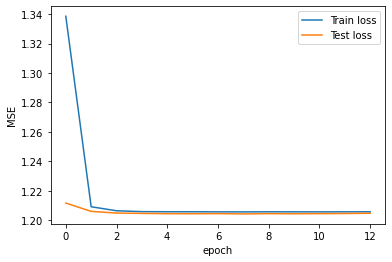

In [18]:
import matplotlib.pyplot as plt
plt.plot(result.history['loss'], label="Train loss")
plt.plot(result.history['val_loss'], label="Test loss")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [19]:
# 테스트 데이터 Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

Actuals: 
        user_id  movie_id  rating
67787      504       187       3
21861      454      1454       2
8661        43       648       5
17491      269       194       5
14777       42       196       5
61672      504       526       3

Predictions: 
 [[3.662129 ]
 [3.404312 ]
 [3.588922 ]
 [3.5062034]
 [3.6421125]
 [3.5773327]]


In [20]:
df6 = ratings_test[0:6]
df6

,user_id,movie_id,rating
67787,504,187,3
21861,454,1454,2
8661,43,648,5
17491,269,194,5
14777,42,196,5
61672,504,526,3


In [21]:
# print(type(predictions))
df6['predictions'] = predictions
df6

C:\ProgramData\Anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,movie_id,rating,predictions
67787,504,187,3,3.662129
21861,454,1454,2,3.404312
8661,43,648,5,3.588922
17491,269,194,5,3.506203
14777,42,196,5,3.642112
61672,504,526,3,3.577333


In [22]:
ratings_test[0:6]

,user_id,movie_id,rating
67787,504,187,3
21861,454,1454,2
8661,43,648,5
17491,269,194,5
14777,42,196,5
61672,504,526,3


In [23]:
df6.sort_values('predictions', ascending=False, inplace=True)
df6

C:\ProgramData\Anaconda3\envs\ai\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,user_id,movie_id,rating,predictions
67787,504,187,3,3.662129
14777,42,196,5,3.642112
8661,43,648,5,3.588922
61672,504,526,3,3.577333
17491,269,194,5,3.506203
21861,454,1454,2,3.404312


In [24]:
# Prediction
user_ids = ratings_test.user_id.values
print(type(user_ids))
print(user_ids.shape)
movie_ids = ratings_test.movie_id.values
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

<class 'numpy.ndarray'>
(25000,)
Actuals: 
        user_id  movie_id  rating
67787      504       187       3
21861      454      1454       2
8661        43       648       5
17491      269       194       5
14777       42       196       5
61672      504       526       3

Predictions: 
 [[3.662129 ]
 [3.404312 ]
 [3.588922 ]
 ...
 [3.602422 ]
 [3.6620188]
 [3.473738 ]]


In [25]:
df = ratings_test.copy()
# print(type(predictions))
df['predictions'] = predictions
df.sort_values('predictions', ascending=False, inplace=True)
df.head(10)

,user_id,movie_id,rating,predictions
73435,312,50,5,3.973458
92997,472,50,5,3.966227
46972,474,50,5,3.956839
58368,862,50,5,3.923599
20320,90,127,4,3.915206
164,90,98,5,3.914058
67309,474,174,5,3.901928
35012,151,50,5,3.901022
15671,200,50,5,3.900492
72244,606,50,5,3.896755


In [26]:
df[df['user_id'] == 1].head(10)

,user_id,movie_id,rating,predictions
4177,1,174,5,3.766321
53552,1,127,5,3.757125
17672,1,100,5,3.739464
20952,1,22,4,3.679488
3260,1,134,4,3.677442
6028,1,96,5,3.656054
4306,1,272,3,3.653570
3246,1,132,4,3.634425
57423,1,195,5,3.632490
15764,1,196,5,3.623076


### 개별 회원 추천

In [27]:
# def RMSE(y_true, y_pred):
#     return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred))) # 전부 더해져서 평균을 Scalar 형태로 변환

# 모델 로딩
model = load_model('./personalization.h5')

# 영화 로딩
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('./data/u.item', sep='|', names=i_cols, encoding='utf-8')
movies = movies.set_index('movie_id')
display(movies.head())

# 평점 로딩
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp'] # 사용자 아이디, 아이템 아이디, 평점 데이터
ratings = pd.read_csv('./data/u.data', names=r_cols,  sep='\t', encoding='utf-8')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거
display(ratings.head())

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [28]:
# 아직 보지 않은 영화 리스트 함수
def get_unseen(ratings, movies, user_id):
     # 특정 user_id가 평점을 매긴 모든 영화 리스트
    seen_movies = ratings[ratings['user_id']== user_id]['movie_id'].tolist()
    
    # 모든 영화명을 list 객체로 만듬. 
#     total_movies = movies['movie_id'].tolist()
    total_movies = movies.index.tolist()
#     print(total_movies)
      
    # 한줄 for + if문으로 안 본 영화 리스트 생성
    unseen_movies = [ movie for movie in total_movies if movie not in seen_movies]
    
    # 일부 정보 출력
    total_movie_cnt = len(total_movies)
    seen_cnt = len(seen_movies)
    unseen_cnt = len(unseen_movies)
    
    print(f"전체 영화 수: {total_movie_cnt}, 평점 매긴 영화 수: {seen_cnt}, 추천 대상 영화 수: {unseen_cnt}")
    
    return unseen_movies

In [29]:
user_id = int(input('회원 번호를 입력하세요(1):'))
unseen_movies = get_unseen(ratings, movies, user_id)
# recomm_movie_by_surprise(model, userId, unseen_movies, top_n=10)

회원 번호를 입력하세요(1):1
전체 영화 수: 1682, 평점 매긴 영화 수: 272, 추천 대상 영화 수: 1410


In [30]:
user_ids = np.array([user_id] * 1410)
user_ids

array([1, 1, 1, ..., 1, 1, 1])

In [31]:
movie_ids = np.array(unseen_movies)
movie_ids

array([ 273,  274,  275, ..., 1680, 1681, 1682])

In [32]:
mu

3.5289733333333335

In [33]:
print(len(unseen_movies))
user_ids = np.array([user_id] * 1410)
print(type(user_ids))
print(user_ids.shape)
movie_ids = np.array(unseen_movies)
print(movie_ids.shape)
predictions = model.predict([user_ids, movie_ids]) + mu
# predictions.shape
display(predictions[:5,0])

1410
<class 'numpy.ndarray'>
(1410,)
(1410,)


array([4.832613 , 4.752425 , 5.0250573, 4.997341 , 4.45771  ],
      dtype=float32)

In [34]:
user_ids_df = pd.DataFrame(user_ids).rename(columns={0:'user_id'})
user_ids_df.head()

,user_id
0,1
1,1
2,1
3,1
4,1


In [35]:
movie_ids_df = pd.DataFrame(movie_ids).rename(columns={0:'movie_id'})
movie_ids_df.head()

,movie_id
0,273
1,274
2,275
3,276
4,277


In [36]:
predictions_df = pd.DataFrame(predictions).rename(columns={0:'prediction'})
predictions_df.head()

,prediction
0,4.832613
1,4.752425
2,5.025057
3,4.997341
4,4.457710


In [37]:
df = pd.concat([user_ids_df, movie_ids_df, predictions_df], axis=1)
df.head()

,user_id,movie_id,prediction
0,1,273,4.832613
1,1,274,4.752425
2,1,275,5.025057
3,1,276,4.997341
4,1,277,4.457710


In [38]:
df.sort_values(['prediction'], ascending=False, inplace=True)
df.head()

,user_id,movie_id,prediction
13,1,286,5.332654
40,1,313,5.265090
15,1,288,5.263471
27,1,300,5.241639
45,1,318,5.178862


In [39]:
df_sub = df.head(100)
df_sub

,user_id,movie_id,prediction
13,1,286,5.332654
40,1,313,5.265090
15,1,288,5.263471
27,1,300,5.241639
45,1,318,5.178862
...,...,...,...
74,1,347,4.633733
417,1,690,4.630438
203,1,476,4.623674
606,1,879,4.622166


In [40]:
movie_ids = df_sub['movie_id']
print(movie_ids)

13     286
40     313
15     288
27     300
45     318
      ... 
74     347
417    690
203    476
606    879
466    739
Name: movie_id, Length: 100, dtype: int32


In [41]:
df_sub['prediction']
print(type(df_sub['prediction']))
print(df_sub['prediction'])

<class 'pandas.core.series.Series'>
13     5.332654
40     5.265090
15     5.263471
27     5.241639
45     5.178862
         ...   
74     4.633733
417    4.630438
203    4.623674
606    4.622166
466    4.619420
Name: prediction, Length: 100, dtype: float32


In [42]:
recom_df = movies.loc[df_sub['movie_id']]
recom_df.head()

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
313,Titanic (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
288,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
300,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
# recom_df['prediction'] = df_sub['prediction'] # ERROR
recom_df['prediction'] = np.array(df_sub['prediction'])
recom_df

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,prediction
movie_id,,,,,,,,,,,,,,,,,,,,,
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,5.332654
313,Titanic (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.265090
288,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,5.263471
300,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,5.241639
318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5.178862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Wag the Dog (1997),09-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.633733
690,Seven Years in Tibet (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Seven+Years+i...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4.630438
476,"First Wives Club, The (1996)",14-Sep-1996,NaN,http://us.imdb.com/M/title-exact?First%20Wives...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.623674


In [44]:
def recomm_movie(model, user_id, unseen_movies, top_n=10, mu=3.5296666666666665):
    user_ids = np.array([user_id] * len(unseen_movies))
    movie_ids = np.array(unseen_movies)
    predictions = model.predict([user_ids, movie_ids]) + mu
    display(predictions[:5,0])
    
    user_ids_df = pd.DataFrame(user_ids).rename(columns={0:'user_id'})
    movie_ids_df = pd.DataFrame(movie_ids).rename(columns={0:'movie_id'})
    predictions_df = pd.DataFrame(predictions).rename(columns={0:'prediction'})
    df = pd.concat([user_ids_df, movie_ids_df, predictions_df], axis=1)
    df.sort_values(['prediction'], ascending=False, inplace=True)
    
    df_sub = df.head(top_n)
    recom_df = movies.loc[df_sub['movie_id']]
    recom_df['prediction'] = np.array(df_sub['prediction'])
    
    return recom_df[['title', 'prediction']]

In [45]:
mu = 3.5296666666666665
model = load_model('./personalization_mu.h5')
user_id = int(input('회원 번호를 입력하세요(1):')) # 1
unseen_movies = get_unseen(ratings, movies, user_id)
df = recomm_movie(model, user_id, unseen_movies, 10, mu)
display(df)

회원 번호를 입력하세요(1):1
전체 영화 수: 1682, 평점 매긴 영화 수: 272, 추천 대상 영화 수: 1410


array([3.542925 , 3.5332704, 3.640953 , 3.6080222, 3.525393 ],
      dtype=float32)

,title,prediction
movie_id,,
318,Schindler's List (1993),3.743489
483,Casablanca (1942),3.719643
357,One Flew Over the Cuckoo's Nest (1975),3.717498
313,Titanic (1997),3.704571
302,L.A. Confidential (1997),3.702015
603,Rear Window (1954),3.687608
427,To Kill a Mockingbird (1962),3.673360
496,It's a Wonderful Life (1946),3.656041
474,Dr. Strangelove or: How I Learned to Stop Worr...,3.655886
